In [1]:
# Example of network training using Pytorch (1.1) and Cuda (9).

# NB: This code use real time monitoring based on Visdom
# an open source webserver allowing real time monitoring
#
# https://github.com/facebookresearch/visdom
#
# Start the webserver using:
# python -m visdom.server
#
# Access it on: (by default)
# http://localhost:8097

# Global import
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from collections import OrderedDict

# Local import
sys.path.insert(0, '../src/pytorch/models/')
from Unet import UNet

sys.path.insert(0, '../src/pytorch/')
from dataset import *
from train import *
from lr_analyzer import *
from criterion import *

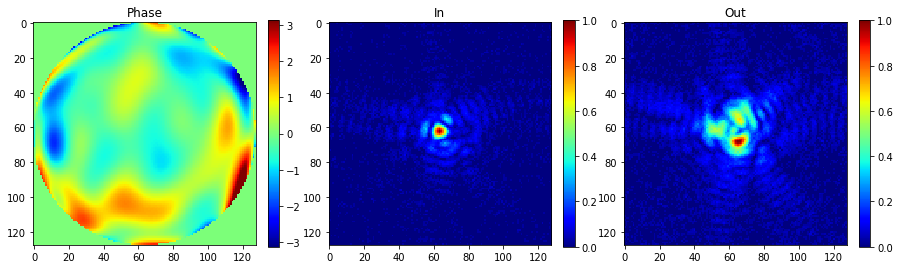

In [2]:
# Load dataset

data_dir = '../dataset/'
dataset_size = 100000
dataset = psf_dataset(root_dir = data_dir, 
                      size = dataset_size,
                      transform = transforms.Compose([Noise(), Normalize(), ToTensor()]))

# Check everything works as expected
import matplotlib.pyplot as plt

id = 0
sample = dataset[id]
phase = sample['phase']
image_in = sample['image'][0]
image_out = sample['image'][1]

f, axarr = plt.subplots(1, 3, figsize=(15, 10))
im1 = axarr[0].imshow(phase, cmap=plt.cm.jet)
im1.set_clim(-np.pi, np.pi)
axarr[0].set_title("Phase")
plt.colorbar(im1, ax = axarr[0], fraction=0.046)
im2 = axarr[1].imshow(image_in, cmap=plt.cm.jet)
axarr[1].set_title("In")
plt.colorbar(im2, ax = axarr[1], fraction=0.046)
im3 = axarr[2].imshow(image_out, cmap=plt.cm.jet)
axarr[2].set_title("Out")
plt.colorbar(im3, ax = axarr[2], fraction=0.046)
plt.show()

In [3]:
# Load model architecture, in this example: Unet 

model = UNet(2, 1)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Move Network to GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    model.cuda()

# Eventually load existing weights

#model_dir = 'ADAM_it2/model.pth'
#state_dict = torch.load(model_dir)
#new_state_dict = OrderedDict()
#for k, v in state_dict.items():
#    name = k[7:] # remove module.
#    new_state_dict[name] = v
#model.load_state_dict(state_dict)

In [ ]:
# Launch training script. The network weights are automatically saved 
# at the end of an epoch (if the test error is reduced). The metrics are also
# saved at the end of each epoch in JSON format. All outputs are also stored in a 
# log file.
#
# - model = network to train
# - dataset = dataset object
# - optimizer = gradient descent optimizer (Adam, SGD, RMSProp)
# - criterion = loss function
# - split[x, 1-x] = Division train/test. 'x' is the proportion of the test set.
# - batch_size = batch size
# - n_epochs = number of epochs
# - model_dir = where to save the results
# - visdom =  enable real time monitoring

train(model, 
      dataset, 
      optimizer, 
      criterion,
      split = [0.50, 0.50],
      batch_size = 64,
      n_epochs = 500,
      model_dir = './',
      visdom = True)